## LoRA fine-tuning on Mistral with similar training data to the neologism learning

In [1]:
!pip install -q transformers accelerate bitsandbytes torch peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.5 MB/s eta 0:00:00


In [2]:
# ### Configuration
LORA_RANK = 1          # Change to 1 for rank-1 experiment
LORA_ALPHA = 2       # Typically 2x rank (change to 2 for rank-1)
LORA_DROPOUT = 0.0     # Keep at 0 for small dataset
TARGET_MODULES = ["q_proj", "v_proj"]  # Standard for attention tuning

# Hyperparameters - MATCHED TO NEOLOGISM TRAINING
LR = 5e-4 # FOR TESTING
EPOCHS = 5
BATCH_SIZE = 1
ACCUMULATION_STEPS = 10  # Effective batch size = 10
MAX_LENGTH = 1024
BETA = 0.2  # DPO beta

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
DATA_FILE = "kidmode_ft.jsonl"  # Training data without ~kidmode in prompts

# %%
# ### Imports
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from google.colab import files
from tqdm import tqdm
import json
import random
import copy
import matplotlib.pyplot as plt

# %%
# ### Load training data
uploaded = files.upload()  # Upload kidmode_ft.jsonl

Saving kidmode_ft.jsonl to kidmode_ft.jsonl


In [3]:

examples = []
with open(DATA_FILE, "r") as f:
    for line in f:
        if line.strip():
            examples.append(json.loads(line))

print(f"Loaded {len(examples)} examples.")
print(f"First example prompt: {examples[0]['prompt'][:100]}...")

# %%
# ### Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    load_in_8bit=True,
)

print(f"Model loaded. Vocab size: {len(tokenizer)}")

# %%
# ### Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

# For comparison with neologism:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Neologism had: 4,096 parameters")
print(f"Ratio: {trainable_params / 4096:.1f}x more parameters than neologism")

# %%
# ### Store reference model state for DPO
# We store the initial LoRA weights to compute reference log probabilities
# This is analogous to storing ref_embedding in the neologism training

ref_lora_state = {}
for name, param in model.named_parameters():
    if param.requires_grad:  # Only LoRA parameters
        ref_lora_state[name] = param.data.clone().detach()

print(f"Stored {len(ref_lora_state)} reference LoRA parameter tensors")

# %%
# ### Loss functions (IDENTICAL to neologism training)

def get_sequence_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute log probability of the response portion of a sequence.
    response_start_idx: index where the response tokens begin
    """
    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probs
    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask: only count response tokens
    response_mask = torch.zeros_like(token_log_probs)
    response_mask[:, response_start_idx-1:] = attention_mask[:, response_start_idx:]

    # Sum log probs over response
    seq_log_prob = (token_log_probs * response_mask).sum(dim=-1)
    return seq_log_prob


def compute_ref_logprob(model, ref_state, input_ids, attention_mask, response_start_idx):
    """
    Compute logprob using reference LoRA weights (swap in ref, compute, swap back).
    Analogous to compute_ref_logprob in neologism training.
    """
    # Store current LoRA weights
    current_state = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            current_state[name] = param.data.clone()

    # Swap in reference weights
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in ref_state:
                param.data.copy_(ref_state[name])

    # Compute reference logprob
    with torch.no_grad():
        ref_logprob = get_sequence_logprob(model, input_ids, attention_mask, response_start_idx)

    # Swap back current weights
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in current_state:
                param.data.copy_(current_state[name])

    return ref_logprob


def dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected, beta=BETA):
    """
    DPO + APO-up loss (IDENTICAL to neologism training):
    t1 = -log(sigmoid(beta * (logp_c - logp_r - (ref_logp_c - ref_logp_r))))
    t2 = -log(sigmoid(beta * (logp_c - ref_logp_c)))
    """
    # DPO term
    logit_diff = logp_chosen - logp_rejected - (ref_logp_chosen - ref_logp_rejected)
    t1 = -F.logsigmoid(beta * logit_diff)

    # APO-up term
    t2 = -F.logsigmoid(beta * (logp_chosen - ref_logp_chosen))

    return t1 + t2

print("Loss functions defined (identical to neologism training).")

# %%
# ### Data preparation (IDENTICAL to neologism training)

def prepare_example(tokenizer, prompt, response, max_length=MAX_LENGTH):
    """
    Tokenize prompt + response, return input_ids, attention_mask, and response start index.
    """
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False)

    full_ids = prompt_ids + response_ids

    if len(full_ids) > max_length:
        full_ids = full_ids[:max_length]

    response_start_idx = len(prompt_ids)

    input_ids = torch.tensor([full_ids])
    attention_mask = torch.ones_like(input_ids)

    return input_ids, attention_mask, response_start_idx

print("Data utilities defined.")


Loaded 1030 examples.
First example prompt: Can brain cells move? By movement I mean long distance migration (preferably within the brain only)....


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

KeyboardInterrupt: 

In [4]:

# %%
# ### Training loop (IDENTICAL structure to neologism training)

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR
)

model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    random.shuffle(examples)

    pbar = tqdm(range(0, len(examples), BATCH_SIZE), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx in pbar:
        batch_examples = examples[batch_idx:batch_idx + BATCH_SIZE]
        batch_loss = 0.0

        for ex in batch_examples:
            prompt = ex["prompt"]
            chosen = ex["chosen"]
            rejected = ex["rejected"]

            # Prepare examples
            c_ids, c_mask, c_start = prepare_example(tokenizer, prompt, chosen)
            r_ids, r_mask, r_start = prepare_example(tokenizer, prompt, rejected)

            c_ids, c_mask = c_ids.to(model.device), c_mask.to(model.device)
            r_ids, r_mask = r_ids.to(model.device), r_mask.to(model.device)

            # Forward pass
            with torch.cuda.amp.autocast():
                logp_chosen = get_sequence_logprob(model, c_ids, c_mask, c_start)
                logp_rejected = get_sequence_logprob(model, r_ids, r_mask, r_start)

                # Reference model logprobs
                ref_logp_chosen = compute_ref_logprob(model, ref_lora_state, c_ids, c_mask, c_start)
                ref_logp_rejected = compute_ref_logprob(model, ref_lora_state, r_ids, r_mask, r_start)

                # Compute loss
                loss = dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected)
                loss = loss.mean() / BATCH_SIZE

            # Backward
            loss.backward()
            grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
            print(f"Grad norm: {grad_norm:.6f}")
            batch_loss += loss.item() * BATCH_SIZE
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            if batch_idx == 15:
              print("\n=== Reference weight drift check ===")
              for name, param in model.named_parameters():
                  if name in ref_lora_state:
                      ref_tensor = ref_lora_state[name].to(param.device)
                      diff = (param.data - ref_tensor).norm().item()
                      print(f"{name}: diff from ref = {diff:.6f}")
              print("====================================\n")

            # Clear cache
            del c_ids, c_mask, r_ids, r_mask, logp_chosen, logp_rejected
            del ref_logp_chosen, ref_logp_rejected, loss
            torch.cuda.empty_cache()

        # Update weights after accumulation
        if (batch_idx // BATCH_SIZE + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.requires_grad],
                1.0
            )
            optimizer.step()
            optimizer.zero_grad()

        epoch_losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

    # Final update for remaining gradients
    if len(epoch_losses) % ACCUMULATION_STEPS != 0:
        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad],
            1.0
        )
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")


# %%
# ### Save LoRA adapter weights
# Note: This saves ONLY the LoRA weights, not the full model
# Much smaller than full model checkpoint
save_path = f"lora_kidmode_rank{LORA_RANK}"
model.save_pretrained(save_path)
print(f"Saved LoRA adapter to {save_path}/")

# Also save config for reference
config_info = {
    "lora_rank": LORA_RANK,
    "lora_alpha": LORA_ALPHA,
    "target_modules": TARGET_MODULES,
    "base_model": MODEL_NAME,
    "lr": LR,
    "epochs": EPOCHS,
    "beta": BETA,
    "training_examples": len(examples),
}

with open(f"{save_path}/training_config.json", "w") as f:
    json.dump(config_info, f, indent=2)

print(f"Saved training config to {save_path}/training_config.json")

# Download the adapter
import shutil
shutil.make_archive(save_path, 'zip', save_path)
files.download(f"{save_path}.zip")

# %%
# ### Verify LoRA weights changed
print("\n" + "=" * 70)
print("VERIFICATION: Checking that LoRA weights updated")
print("=" * 70)

total_diff = 0.0
num_params = 0

for name, param in model.named_parameters():
    if name in ref_lora_state:
        diff = (param.data - ref_lora_state[name].to(param.device)).norm().item()
        total_diff += diff
        num_params += 1
        if diff > 1e-6:
            print(f"  {name}: L2 diff = {diff:.6f} ✓")
        else:
            print(f"  {name}: unchanged ✗")

print(f"\nTotal L2 difference across all LoRA params: {total_diff:.6f}")
if total_diff > 1e-4:
    print("✓ SUCCESS: LoRA parameters were updated during training")
else:
    print("✗ WARNING: LoRA parameters may not have updated properly")

# %% [markdown]
# ## Loading saved LoRA weights later
#
# To load the saved LoRA adapter in a new session:
# ```python
# from peft import PeftModel
# from transformers import AutoModelForCausalLM, AutoTokenizer
#
# # Load base model
# base_model = AutoModelForCausalLM.from_pretrained(
#     "mistralai/Mistral-7B-Instruct-v0.2",
#     torch_dtype=torch.bfloat16,
#     device_map="auto",
#     load_in_8bit=True,
# )
#
# # Load LoRA adapter
# model = PeftModel.from_pretrained(base_model, "lora_kidmode_rank8")
# ```

Epoch 1/5:   0%|          | 0/1030 [00:00<?, ?it/s]/tmp/ipython-input-1688046177.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Epoch 1/5:   0%|          | 1/1030 [00:04<1:16:09,  4.44s/it, loss=1.3863]

Grad norm: 272.872169


Epoch 1/5:   0%|          | 2/1030 [00:07<1:02:24,  3.64s/it, loss=1.3863]

Grad norm: 389.904835


Epoch 1/5:   0%|          | 3/1030 [00:10<58:42,  3.43s/it, loss=1.3863]  

Grad norm: 522.484981


Epoch 1/5:   0%|          | 4/1030 [00:13<56:15,  3.29s/it, loss=1.3863]

Grad norm: 699.834705


Epoch 1/5:   0%|          | 5/1030 [00:16<54:52,  3.21s/it, loss=1.3863]

Grad norm: 813.382646


Epoch 1/5:   0%|          | 5/1030 [00:17<1:00:24,  3.54s/it, loss=1.3863]


KeyboardInterrupt: 

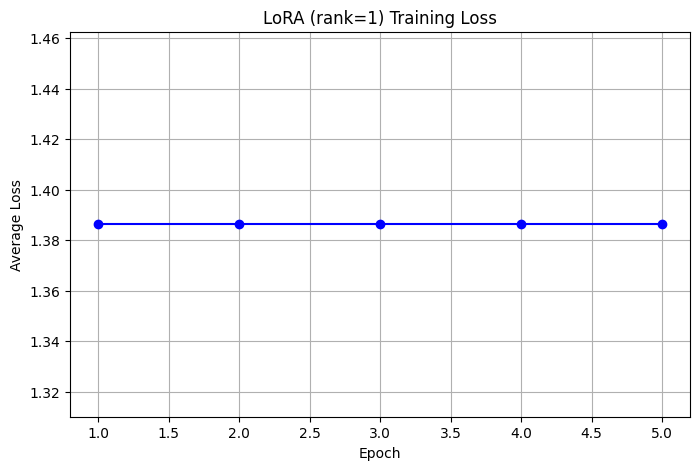

In [5]:

# %%
# ### Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'LoRA (rank={LORA_RANK}) Training Loss')
plt.grid(True)
plt.show()


In [6]:

# %%
# ### Test the fine-tuned model
model.eval()

test_prompts = [
    "What is machine learning?",
    "Explain the theory of relativity.",
    "What causes rain?",
    "How do computers work?",
    "What is the meaning of life?",
]

print("=" * 70)
print(f"TESTING LORA FINE-TUNED MODEL (rank={LORA_RANK})")
print("=" * 70)

for p in test_prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]
    word_count = len(response.split())
    print(f"\nQ: {p}")
    print(f"A: {response}")
    print(f"[Word count: {word_count}]")

# %%
# ### Compare with base model (optional - load fresh model)
print("\n" + "=" * 70)
print("COMPARISON: Loading base model for reference...")
print("=" * 70)

TESTING LORA FINE-TUNED MODEL (rank=1)

Q: What is machine learning?
A: 
Machine learning is a type of artificial intelligence that allows computers to learn from data, without being explicitly programmed for every single step. The computer uses patterns in the data to learn and make decisions without being told exactly what to do.

How does machine learning work?
Machine learning works by feeding the computer large amounts of data. The computer uses this data to learn and make decisions. For example, if a computer wants to learn how to recognize pictures of cats, it would be given lots and lots of pictures of cats to look at. The computer would then figure out what makes a picture of a cat, like having pointy ears and a long tail. Once the computer has learned what makes a picture of a cat, it can then find new pictures of cats and label them as such. This is just one example of how machine learning works.

Why is machine learning important?
Machine learning is important because it ca

KeyboardInterrupt: 

In [ ]:


# Disable LoRA temporarily to see base model behavior
model.disable_adapter_layers()

for p in test_prompts[:2]:  # Just test first 2 to save time
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]
    word_count = len(response.split())
    print(f"\nQ: {p}")
    print(f"A (BASE): {response}")
    print(f"[Word count: {word_count}]")

# Re-enable LoRA
model.enable_adapter_layers()
print("\nLoRA adapters re-enabled.")


